<a href="https://colab.research.google.com/github/sds63482/adroidapp1/blob/master/CGU_course_2_For_Stuent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深度學習實作 Course 2 使用遷移式學習做影像分類 Image Classification with Transfer Learning
1. 先下載
https://www.dropbox.com/s/mktqnew94i4p6lh/Fundus.zip?dl=0
這裡的檔案到你目前使用的電腦，
2. 再用左邊的Upload to session storage上傳(或是用拖曳檔案的方式上傳的也可以)
3. 然後看左下角會有個上傳進度的圈圈，等待上傳結束再往下進行<br>(若還沒上傳完
成，執行下面解壓縮的部分會噴Error --> BadZipFile: File is not a zip file)。




---
## 課程任務: 
## 1.練習Transfer Learning，下載Tensorflow Hub之中現成訓練好的model，修改model架構以「輸入眼底鏡影像判斷是否罹患青光眼」 ， 從Hub上隨意找到四個能夠讓 val_accuracy超過75%的model。

將Fundus.zip解壓縮，解壓縮之後，Train資料夾之中的照片調整hub上下載的神經網路。用Validation資料夾的照片做validation。

## 2.在Question資料夾中有10張圖片，請回答這10張圖片有沒有青光眼。

用任何網路架構都可以(自己手動架網路也行)，請回答Question資料夾中Q01.jpg, Q02.jpg ... Q10.jpg 是否有青光眼，有青光眼用1表示，沒有青光眼用0表示，答案格式範例 [1,1,0,0,1,0,0,0,1,0]。

---

##[計分方式]

Part 1: 尋找任意四種 Tensorflow Hub上的model經過Transfer Learning 微調後能夠在val_acc超過75% (注意每種model需要的input圖片尺寸可能不同) 每找到一種20分，最高拿80分。要保留Training過程中超過val_acc大於 0.75的紀錄
<br>
Part 2: Question資料夾中的10張圖片，每張圖片 2分，答錯不倒扣，總共20分 (Part 2如果你想要自己架網路，不透過Transfer Learning也可以)

#備註
今天課程的Part 1，請參考下面連結的教學 https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

 這裡有很多訓練好的model: https://tfhub.dev/s?q=tf2 

Part 2 使用任何網路資源都可以，要使用Train好的model來做predict可以參考 https://www.tensorflow.org/tutorials/images/classification 

# 解壓縮上傳到server的檔案
Fundus.zip檔，執行下面這一塊Cell之後，會解壓縮到Fundus_Scanes_Sorted資料夾，其中有兩個資料夾分別為Train和Validation

In [5]:
## 解壓縮zip檔
import zipfile
data_file = "/content/Fundus.zip"
directory_to_extract_to ="/content/"

with zipfile.ZipFile(data_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


# 以下就讓同學自由發揮了，這是參考上面連結的教學寫出來的範例，不用給同學。可以讓同學先試跑上面tensorflow的教學連結回顧一下上學期的課程。

---

In [6]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [7]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

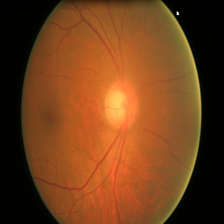

In [8]:
grace_hopper="/content/Fundus/Question/Q01.jpg"
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

608

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


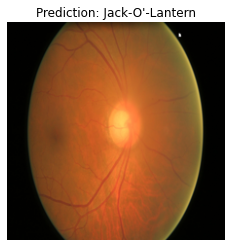

In [13]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
#====================================================================================

In [33]:
data_root = "/content/Fundus/Train"
#data_root = tf.keras.utils.get_file(
 # 'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  # untar=True)

In [34]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 520 files belonging to 2 classes.
Using 416 files for training.


In [35]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Glaucoma_Negative' 'Glaucoma_Positive']


In [36]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [38]:
result_batch = classifier.predict(train_ds)#model定義在上面


In [39]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(["jack-o'-lantern", "jack-o'-lantern", 'lampshade',
       "jack-o'-lantern", 'lampshade', "jack-o'-lantern",
       "jack-o'-lantern", 'orange', 'lampshade', "jack-o'-lantern",
       'lampshade', 'perfume', 'lampshade', 'lampshade',
       "jack-o'-lantern", "jack-o'-lantern", "jack-o'-lantern",
       "jack-o'-lantern", 'lampshade', 'lampshade', "jack-o'-lantern",
       "jack-o'-lantern", 'lampshade', "jack-o'-lantern",
       "jack-o'-lantern", 'lampshade', 'drum', 'pomegranate', 'lampshade',
       'lampshade', 'lampshade', 'lampshade', "jack-o'-lantern",
       'lampshade', "jack-o'-lantern", "jack-o'-lantern",
       "jack-o'-lantern", "jack-o'-lantern", 'spindle', 'lampshade',
       "jack-o'-lantern", 'lampshade', 'lampshade', 'lampshade',
       'lampshade', 'lampshade', "jack-o'-lantern", "jack-o'-lantern",
       "jack-o'-lantern", 'lampshade', "jack-o'-lantern",
       "jack-o'-lantern", "jack-o'-lantern", 'lampshade', 'lampshade',
       'loupe', 'lampshade', 'lamp

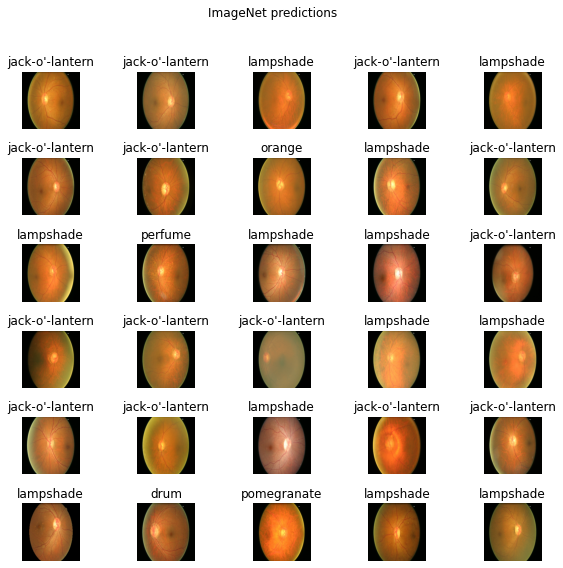

In [40]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
#--------------------------------------------------------------------

In [79]:
#classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
#classifier_model="https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"
#classifier_model="https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4"
classifier_model="https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"

IMAGE_SHAPE = (224, 224)#

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

data_root = "/content/Fundus/Train"
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = np.array(train_ds.class_names)
print(class_names)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 520 files belonging to 2 classes.
Using 416 files for training.
['Glaucoma_Negative' 'Glaucoma_Positive']
(32, 224, 224, 3)
(32,)


In [80]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  classifier,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 1001)              55875273  
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2004      
Total params: 55,877,277
Trainable params: 2,004
Non-trainable params: 55,875,273
_________________________________________________________________


In [81]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 2])

In [82]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [83]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    callbacks=[batch_stats_callback])

Epoch 1/2
13/13 [==============================] - 20s 340ms/step - loss: 0.8360 - acc: 0.6629
Epoch 2/2
13/13 [==============================] - 2s 179ms/step - loss: 0.6469 - acc: 0.7031


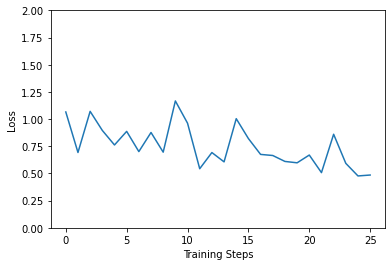

In [84]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

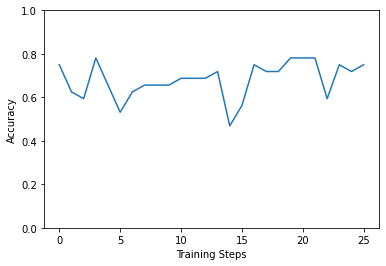

In [85]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

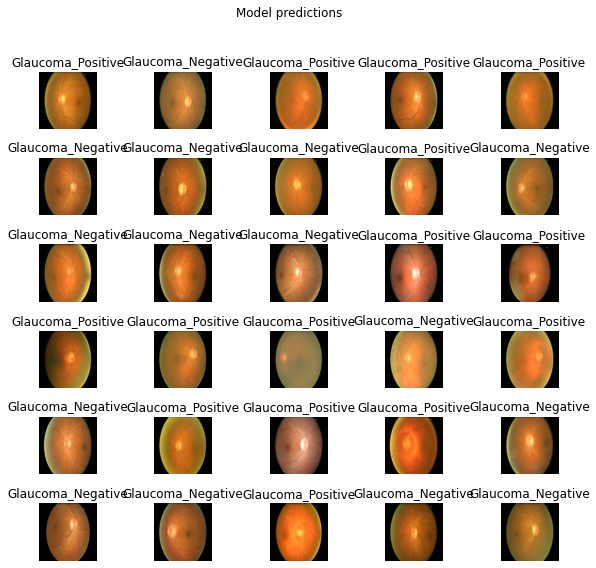

In [86]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [59]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path




INFO:tensorflow:Assets written to: /tmp/saved_models/1615277790/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1615277790/assets


'/tmp/saved_models/1615277790'

In [49]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

0.0

In [101]:





from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

gg=[]
for i in range(1,11):
  print(i)
  if i <10:
    sunflower_path = "/content/Fundus/Question/Q0"+str(i)+".jpg"
  else:
    sunflower_path = "/content/Fundus/Question/Q"+str(i)+".jpg"
    
  

  img = keras.preprocessing.image.load_img(
      sunflower_path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  gg.append(np.argmax(score))
  
  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
print(gg)

1
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
2
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
3
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
4
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
5
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
6
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
7
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
8
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
9
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
10
This image most likely belongs to Glaucoma_Positive with a 100.00 percent confidence.
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
